# Generative Adversarial Networks 
[A paper by Ian Goodfellow in 2014 ](https://arxiv.org/pdf/1406.2661.pdf)

A type of Neural Nets. That are Used to train generative networks through an adversarial process.

Allow a network to learn to generate data with the same internal structure as other data. 

<img src=images/GAN.png >

It consists of Two Neural Networks 
    1. Generator Network  G -  Captures the Data Distribution
    
    2. Discriminator Netowk  D - estimates the Probability of image either coming from the generator or it's a real image.


D and G play the following two-player minimax game :

<img src=images/img1.png >

Lets dive in to the implementation part 

In [ ]:
# First Lets import all nessesry parts 
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

Xavier Glorot and Yoshua Bengio (2010)
This initializer is designed to keep the scale of the gradients roughly the same in all layers.

In [ ]:
# this is a simple weight initializer 
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [ ]:
X = tf.placeholder(tf.float32, shape=[None, 784])
Z = tf.placeholder(tf.float32, shape=[None, 100])

In [ ]:
D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

we made the generator Simple MLP

In [ ]:
G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [ ]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

The Generator 
<img src="images/GEN.png" >

In [ ]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

The Discrminator

<img src="images/desc.png">

In [ ]:
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [ ]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [ ]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

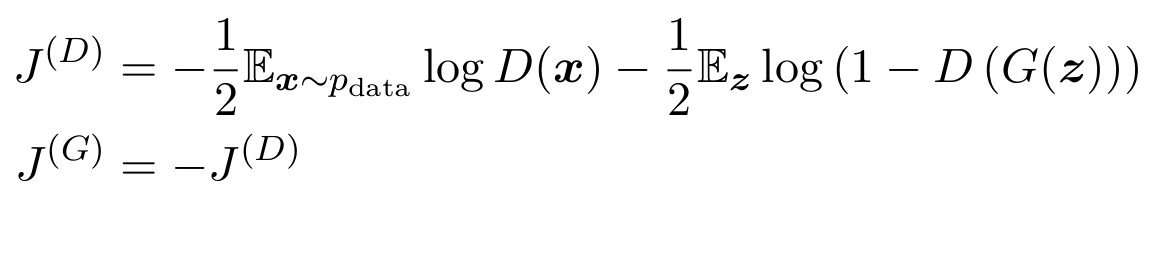
or
The paper mentions experemental loss
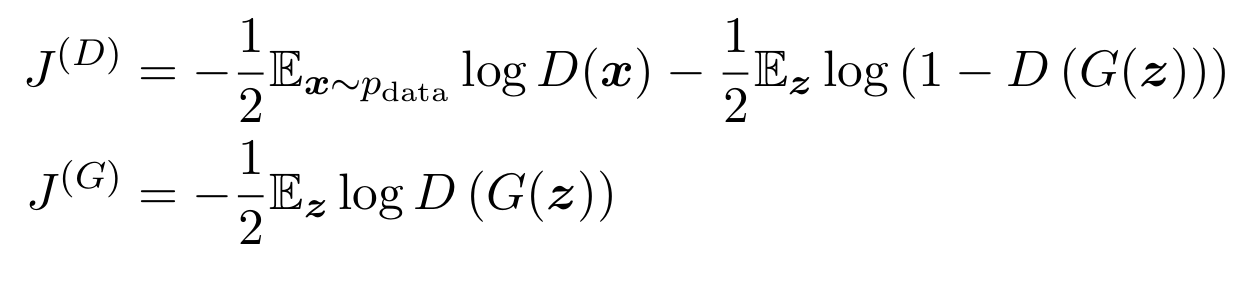

In [ ]:
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

In [ ]:

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [ ]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [ ]:
mb_size = 128
Z_dim = 100

In [ ]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

### Training Process
<img src="images/training.png" >

<img src="images/algorithm.png" >

In [ ]:
for it in range(1000000):
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, _ = mnist.train.next_batch(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
        

## GAN Training Problems 
 
   

Training difficultly. 
        Sometimes the models will never learn anything or converge to a local minima.
        
Mode collapse
    which is where the generator essentially outputs the same thing over and over.
    
No Measure of Accuracy 
    can be both as Positive and Negative 

### Some Useful GAN Variants 
1.[UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS](https://arxiv.org/pdf/1511.06434.pdf)

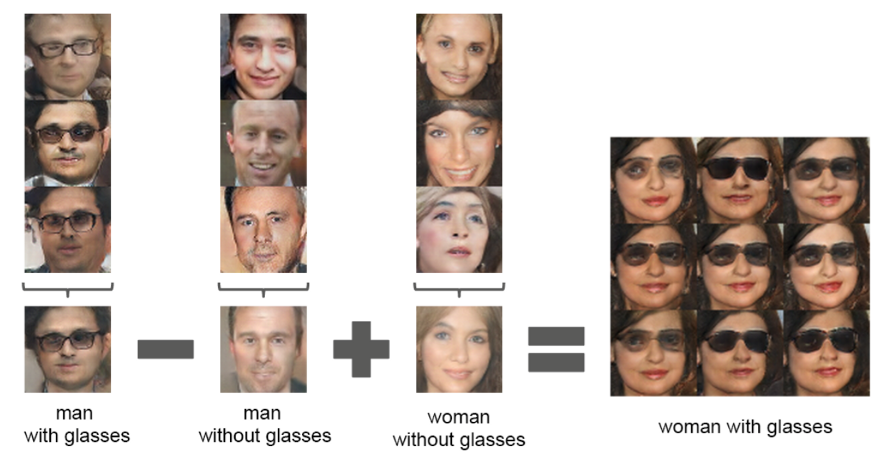
2.[Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)

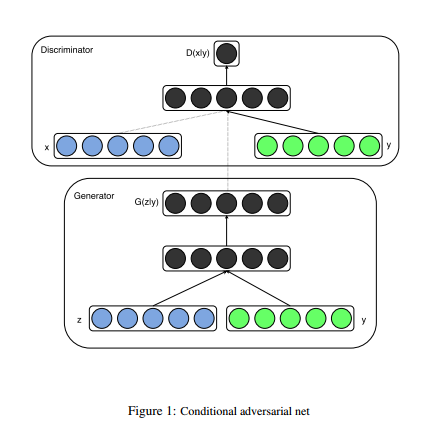

3.[Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028.pdf)

    1. Clip the weight of D
    2. Train D  more than G
    3. Use RMSProp instead of ADAM
    4. Lower learning rate, the paper uses α = 0.00005

4.[InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets](https://arxiv.org/pdf/1606.03657.pdf)

### Interesting Application Of GANS

[Music Generation](https://arxiv.org/pdf/1703.10847.pdf)

[Disco GAN ](https://arxiv.org/pdf/1703.05192.pdf)

[Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/pdf/1609.04802.pdf)

[Generative Adversarial Text to Image Synthesis](https://arxiv.org/pdf/1605.05396)

### Additional Resources

Blog - [Paper Implementation And Description](https://theneuralperspective.com/)

Vid - [Detail Paper presentation By the Autor](https://www.youtube.com/watch?v=AJVyzd0rqdc&t=307s)